# 02. Preprocessed Data Assessment

**Pipeline Stage:** Preprocessed ManyLabs1 Data (Long Format)

**Objective:** Assess the preprocessed data structure after transformation from wide to long format, verify study/site structure, and evaluate readiness for OSRCT generation.

**Data Source:** `Manylabs1_data.pkl` / `Manylabs1_data.csv`

---

## Contents
1. Data Loading and Structure
2. Study-Level Analysis
3. Site-Level Analysis
4. Treatment and Outcome Assessment
5. Covariate Quality
6. Ground Truth ATE Estimation
7. Assessment for OSRCT

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

# Paths
DATA_PATH_PKL = '../ManyLabs1/pre-process/Manylabs1_data.pkl'
DATA_PATH_CSV = '../ManyLabs1/pre-process/Manylabs1_data.csv'

---
## 1. Data Loading and Structure

In [56]:
# Load preprocessed data
try:
    df = pd.read_pickle(DATA_PATH_PKL)
    print("Loaded from pickle")
except:
    df = pd.read_csv(DATA_PATH_CSV)
    print("Loaded from CSV")

print(f"\nDATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Observations: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loaded from pickle

DATASET OVERVIEW
Shape: (89979, 48)
Observations: 89,979
Variables: 48
Memory: 125.4 MB


In [57]:
# Column structure
print("\nCOLUMN STRUCTURE")
print("=" * 60)
for col in df.columns:
    dtype = str(df[col].dtype)
    n_unique = df[col].nunique()
    n_null = df[col].isnull().sum()
    sample = df[col].dropna().iloc[0] if df[col].notna().any() else None
    print(f"{col:25s} | {dtype:10s} | unique: {n_unique:6d} | null: {n_null:6d} | sample: {sample}")


COLUMN STRUCTURE
id                        | float64    | unique:   6344 | null:      0 | sample: 2400853.0
date                      | datetime64[ns] | unique:   6303 | null:      0 | sample: 2013-08-28 12:15:55
site                      | object     | unique:     36 | null:      0 | sample: abington
resp_sex                  | object     | unique:      2 | null:    112 | sample: female
resp_age                  | float64    | unique:     78 | null:      0 | sample: 18.0
resp_race                 | object     | unique:     28 | null:      0 | sample: east asian
resp_ethnicity            | object     | unique:      2 | null:  19364 | sample: not hispanic or latino
resp_citizenship          | object     | unique:    101 | null:    183 | sample: US
resp_major                | object     | unique:     13 | null:  17635 | sample: Law or legal studies
resp_pid                  | object     | unique:      7 | null:   2039 | sample: Strongly Liberal
resp_nativelang           | object     | u

In [58]:
# First rows
print("\nSAMPLE ROWS")
df.head(10)


SAMPLE ROWS


,id,date,site,resp_sex,resp_age,resp_race,resp_ethnicity,resp_citizenship,resp_major,resp_pid,resp_nativelang,resp_religion,resp_american,resp_american_pid,resp_american_ideo,exp_sex,exp_race,study_numparticipants,study_exprunafter,study_separated,study_recruit,study_compensation,study_online,study_country,study_usa,filter_iat,iv,dv,original_study,original_study_name,resp_gender,resp_ethnicity_hisp,RACE,RACE_american_indian,RACE_black_american,RACE_brazil,RACE_east_asian,RACE_more_than_one,RACE_nederland,RACE_others,RACE_south_asian,RACE_white,MAJOR,MAJOR_Engineer,MAJOR_Science,MAJOR_Social,MAJOR_others,resp_polideo
0,2400853.000,2013-08-28 12:15:55,abington,female,18.000,east asian,NaN,US,Law or legal studies,Strongly Liberal,english,NaN,11.000,4.000,4.000,male,white,5,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,1.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",1.000,0.170,east_asian,False,False,False,True,False,False,False,False,False,Social,False,False,True,False,6.000
1,2400856.000,2013-08-28 12:13:49,abington,female,19.000,south asian,NaN,CN,Visual and performing arts,Neutral (Moderate),other,NaN,6.000,7.000,4.000,male,white,5,runafter,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",1.000,0.170,south_asian,False,False,False,False,False,False,False,True,False,others,False,False,False,True,3.000
2,2400860.000,2013-08-28 12:15:57,abington,female,18.000,white,not hispanic or latino,US,Visual and performing arts,Moderately Conservative,other,NaN,4.000,5.000,5.000,male,white,5,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",1.000,0.000,white,False,False,False,False,False,False,False,False,True,others,False,False,False,True,1.000
3,2400868.000,2013-08-28 12:12:21,abington,male,18.000,white,not hispanic or latino,US,Biological sciences/life sciences,Neutral (Moderate),english,NaN,8.000,4.000,4.000,male,white,5,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,1.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",0.000,0.000,white,False,False,False,False,False,False,False,False,True,Science,False,True,False,False,3.000
4,2400872.000,2013-08-28 12:11:58,abington,male,18.000,white,not hispanic or latino,US,"Engineering, mathematics, physical sciences/te...",Strongly Conservative,english,NaN,11.000,5.000,5.000,male,white,NaN,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",0.000,0.000,white,False,False,False,False,False,False,False,False,True,Engineer,True,False,False,False,0.000
5,2400914.000,2013-08-28 12:19:46,abington,female,18.000,south asian,not hispanic or latino,US,"Engineering, mathematics, physical sciences/te...",Neutral (Moderate),english,NaN,11.000,3.000,3.000,male,white,5,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,0.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",1.000,0.000,south_asian,False,False,False,False,False,False,False,True,False,Engineer,True,False,False,False,3.000
6,2400916.000,2013-08-28 12:19:14,abington,female,18.000,south asian,not hispanic or latino,US,"Engineering, mathematics, physical sciences/te...",Neutral (Moderate),english,NaN,11.000,4.000,4.000,male,white,5,runalone,nobarriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",1.000,0.000,south_asian,False,False,False,False,False,False,False,True,False,Engineer,True,False,False,False,3.000
7,2400925.000,2013-08-28 12:16:21,abington,male,19.000,east asian,NaN,US,Education,Neutral (Moderate),english,NaN,7.000,3.000,6.000,male,white,5,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,1.000,allowedforbidden,"Allowed/Forbidden (Rugg, 1941)",0.000,0.170,east_asian,False,False,False,True,False,False,False,False,False,Social,False,False,True,False,3.000
8,2400934.000,2013-08-28 12:22:38,abington,

---
## 2. Study-Level Analysis

In [59]:
# Identify study column
study_col = 'original_study' if 'original_study' in df.columns else 'study'

print(f"STUDY-LEVEL SUMMARY (column: {study_col})")
print("=" * 60)

# Study counts
study_summary = df.groupby(study_col).agg(
    n_obs=('iv', 'count'),
    n_treated=('iv', 'sum'),
    n_control=('iv', lambda x: (x == 0).sum()),
    mean_outcome=('dv', 'mean'),
    std_outcome=('dv', 'std'),
    n_sites=('site', 'nunique') if 'site' in df.columns else ('iv', lambda x: 1)
).round(3)

study_summary['treatment_rate'] = (study_summary['n_treated'] / study_summary['n_obs']).round(3)
study_summary = study_summary.sort_values('n_obs', ascending=False)

print(f"\nNumber of studies: {df[study_col].nunique()}")
print(f"Total observations: {len(df):,}")
print(f"\n{study_summary}")

STUDY-LEVEL SUMMARY (column: original_study)

Number of studies: 15
Total observations: 89,979

                  n_obs  n_treated  n_control  mean_outcome  std_outcome  \
original_study                                                             
contact            6336   3172.000       3164         4.708        1.942   
money              6333   3138.000       3195         3.587        0.991   
sunk               6330   3243.000       3087         7.554        2.247   
quote              6325   3242.000       3083         5.589        2.189   
allowedforbidden   6292   3122.000       3170         0.846        0.361   
reciprocity        6276   3074.000       3202         0.705        0.456   
gainloss           6271   3097.000       3174         1.520        0.500   
flag               6251   3106.000       3145         3.088        1.010   
gambfal            5942   2680.000       3262         2.831        2.838   
scales             5899   2820.000       3079         0.155        0

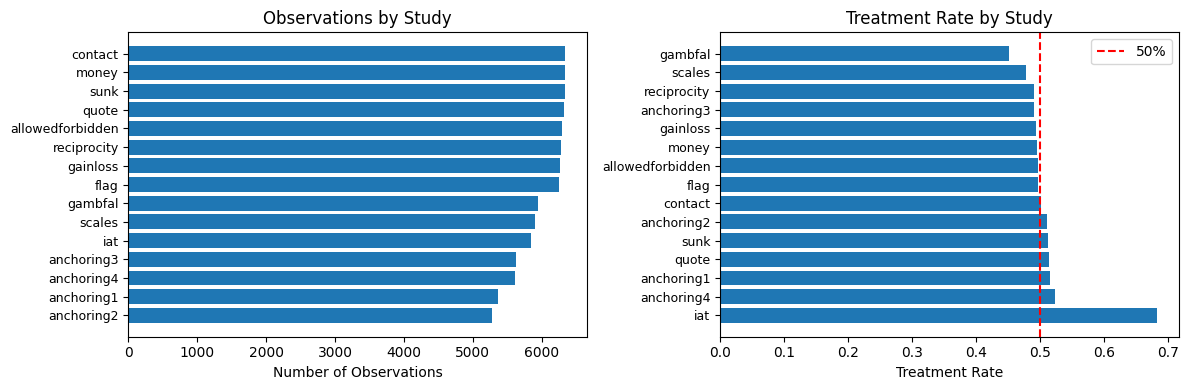

In [60]:
# Study size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of study sizes
study_counts = df[study_col].value_counts()
axes[0].barh(range(len(study_counts)), study_counts.values)
axes[0].set_yticks(range(len(study_counts)))
axes[0].set_yticklabels(study_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Observations')
axes[0].set_title('Observations by Study')
axes[0].invert_yaxis()

# Treatment rates
treatment_rates = study_summary['treatment_rate'].sort_values()
axes[1].barh(range(len(treatment_rates)), treatment_rates.values)
axes[1].set_yticks(range(len(treatment_rates)))
axes[1].set_yticklabels(treatment_rates.index, fontsize=9)
axes[1].axvline(x=0.5, color='red', linestyle='--', label='50%')
axes[1].set_xlabel('Treatment Rate')
axes[1].set_title('Treatment Rate by Study')
axes[1].invert_yaxis()
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 3. Site-Level Analysis

In [61]:
# Site analysis
if 'site' in df.columns:
    print("SITE-LEVEL SUMMARY")
    print("=" * 60)
    
    site_summary = df.groupby('site').agg(
        n_obs=('iv', 'count'),
        n_studies=('original_study' if 'original_study' in df.columns else study_col, 'nunique'),
        treatment_rate=('iv', 'mean')
    ).round(3).sort_values('n_obs', ascending=False)
    
    print(f"\nNumber of sites: {df['site'].nunique()}")
    print(f"\nSite size distribution:")
    print(site_summary['n_obs'].describe())
    print(f"\nTop 15 sites by size:")
    print(site_summary.head(15))
else:
    print("No site column found")

SITE-LEVEL SUMMARY

Number of sites: 36

Site size distribution:
count      36.000
mean     2499.417
std      3593.348
min      1087.000
25%      1279.250
50%      1460.000
75%      1956.000
max     18948.000
Name: n_obs, dtype: float64

Top 15 sites by size:
          n_obs  n_studies  treatment_rate
site                                      
pi        18948         15           0.506
mturk     14497         15           0.504
lse        3953         15           0.513
tamuon     3214         15           0.533
tamu       2661         15           0.526
jmu        2497         15           0.530
sdsu       2341         15           0.525
swpson     2299         15           0.510
luc        2082         15           0.517
unipd      1914         15           0.490
ufl        1837         15           0.513
oxy        1731         15           0.504
brasilia   1582         15           0.520
laurier    1555         15           0.501
vcu        1550         15           0.519


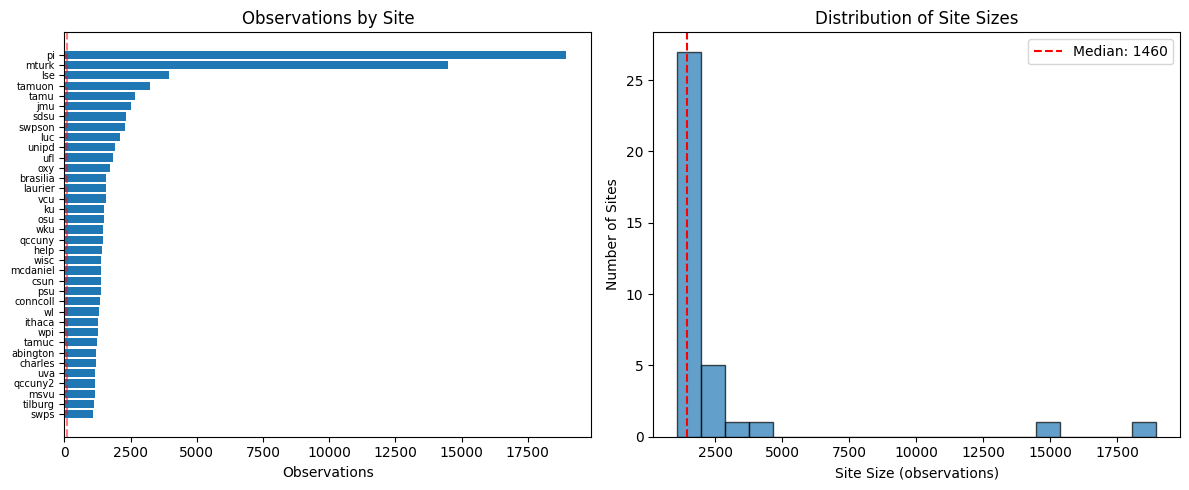

In [62]:
# Site size visualization
if 'site' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Site sizes
    site_counts = df['site'].value_counts()
    axes[0].barh(range(len(site_counts)), site_counts.values)
    axes[0].set_yticks(range(len(site_counts)))
    axes[0].set_yticklabels(site_counts.index, fontsize=7)
    axes[0].set_xlabel('Observations')
    axes[0].set_title('Observations by Site')
    axes[0].invert_yaxis()
    axes[0].axvline(x=100, color='red', linestyle='--', alpha=0.5)
    
    # Site size histogram
    axes[1].hist(site_counts.values, bins=20, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Site Size (observations)')
    axes[1].set_ylabel('Number of Sites')
    axes[1].set_title('Distribution of Site Sizes')
    axes[1].axvline(x=site_counts.median(), color='red', linestyle='--', label=f'Median: {site_counts.median():.0f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

---
## 4. Treatment and Outcome Assessment

In [63]:
# Treatment variable (iv)
print("TREATMENT VARIABLE (iv)")
print("=" * 60)
print(f"\nValue counts:")
print(df['iv'].value_counts())
print(f"\nOverall treatment rate: {df['iv'].mean():.3f}")
print(f"Missing: {df['iv'].isnull().sum()}")

TREATMENT VARIABLE (iv)

Value counts:
iv
1.000    45833
0.000    44146
Name: count, dtype: int64

Overall treatment rate: 0.509
Missing: 0


In [64]:
# Outcome variable (dv) by study
print("\nOUTCOME VARIABLE (dv) BY STUDY")
print("=" * 60)

outcome_summary = df.groupby(study_col).agg(
    mean_dv=('dv', 'mean'),
    std_dv=('dv', 'std'),
    min_dv=('dv', 'min'),
    max_dv=('dv', 'max'),
    n_unique_dv=('dv', 'nunique'),
    pct_missing=('dv', lambda x: x.isnull().mean() * 100)
).round(3)

print(outcome_summary)


OUTCOME VARIABLE (dv) BY STUDY
                  mean_dv   std_dv  min_dv   max_dv  n_unique_dv  pct_missing
original_study                                                               
allowedforbidden    0.846    0.361   0.000    1.000            2        0.000
anchoring1       2681.500 1538.915   8.000 5352.000          454        0.000
anchoring2       2642.500 1521.588   5.500 5271.000          464        0.000
anchoring3       2814.000 1623.830   2.500 5614.000          765        0.000
anchoring4       2805.000 1617.597  13.000 5598.500          386        0.000
contact             4.708    1.942   1.000    9.000           37        0.000
flag                3.088    1.010   1.000    6.875           87        0.000
gainloss            1.520    0.500   1.000    2.000            2        0.000
gambfal             2.831    2.838   0.000   24.495          113        0.000
iat                 0.441    0.495  -1.394    1.594         5842        0.000
money               3.587    0.9

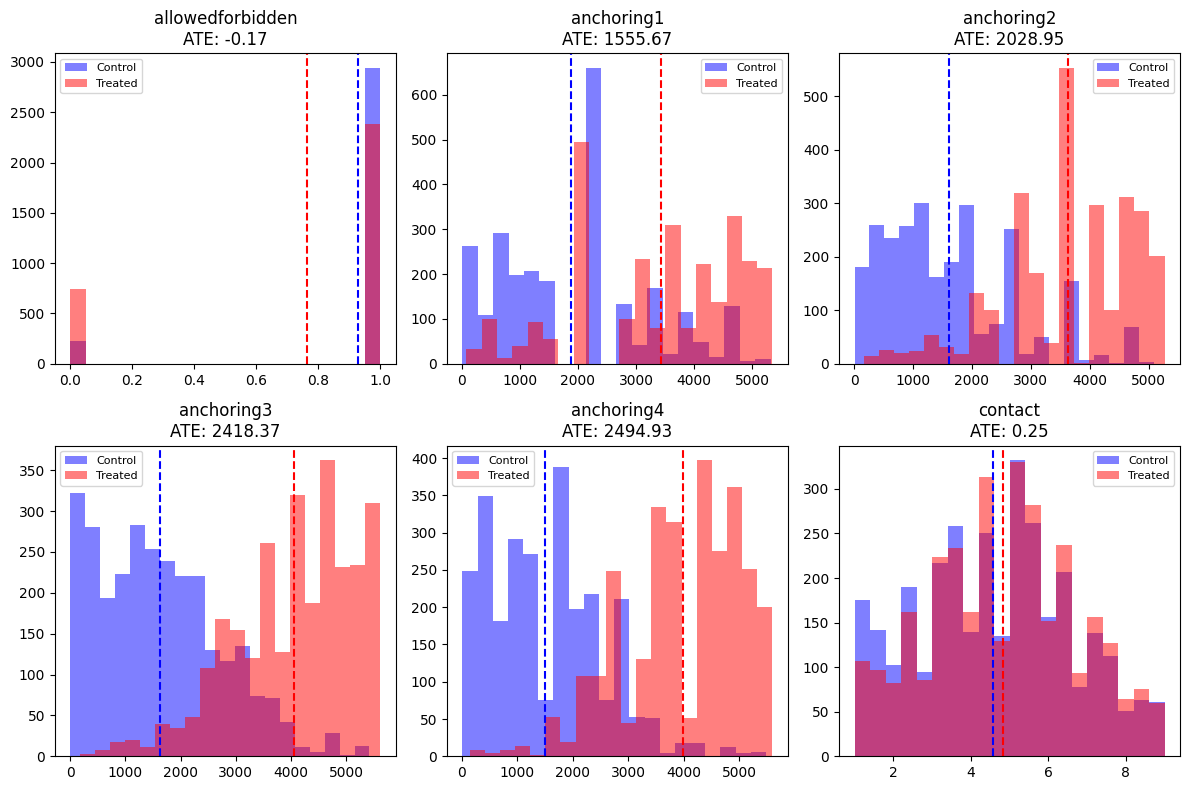

In [65]:
# Outcome distributions by study (sample of studies)
studies = df[study_col].unique()[:6]  # First 6 studies
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, study in zip(axes, studies):
    study_data = df[df[study_col] == study]
    
    # Plot treated vs control
    treated = study_data[study_data['iv'] == 1]['dv'].dropna()
    control = study_data[study_data['iv'] == 0]['dv'].dropna()
    
    ax.hist(control, bins=20, alpha=0.5, label='Control', color='blue')
    ax.hist(treated, bins=20, alpha=0.5, label='Treated', color='red')
    ax.axvline(control.mean(), color='blue', linestyle='--')
    ax.axvline(treated.mean(), color='red', linestyle='--')
    ax.set_title(f'{study}\nATE: {treated.mean() - control.mean():.2f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## 5. Covariate Quality

In [66]:
# Key covariates for OSRCT
covariates = ['resp_age', 'resp_gender', 'resp_polideo']
available_covs = [c for c in covariates if c in df.columns]

print("COVARIATE QUALITY ASSESSMENT")
print("=" * 60)

cov_quality = []
for cov in available_covs:
    cov_data = df[cov]
    quality = {
        'covariate': cov,
        'n_valid': cov_data.notna().sum(),
        'pct_valid': cov_data.notna().mean() * 100,
        'n_unique': cov_data.nunique(),
        'dtype': str(cov_data.dtype)
    }
    
    if cov_data.dtype in ['float64', 'int64']:
        quality['mean'] = cov_data.mean()
        quality['std'] = cov_data.std()
        quality['min'] = cov_data.min()
        quality['max'] = cov_data.max()
    
    cov_quality.append(quality)

cov_df = pd.DataFrame(cov_quality)
print(cov_df.to_string(index=False))

COVARIATE QUALITY ASSESSMENT
   covariate  n_valid  pct_valid  n_unique   dtype   mean    std    min     max
    resp_age    89979    100.000        78 float64 26.012 11.358 12.000 100.000
 resp_gender    89979    100.000         9 float64  0.674  0.469  0.000   1.000
resp_polideo    89979    100.000        38 float64  3.448  1.571  0.000   6.000


In [67]:
# Covariate balance by treatment (should be balanced in RCT)
print("\nCOVARIATE BALANCE BY TREATMENT")
print("=" * 60)
print("(In RCT, covariates should be balanced between treatment groups)\n")

for cov in available_covs:
    treated = df[df['iv'] == 1][cov].dropna()
    control = df[df['iv'] == 0][cov].dropna()
    
    # Standardized mean difference
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    smd = (treated.mean() - control.mean()) / pooled_std if pooled_std > 0 else 0
    
    print(f"{cov}:")
    print(f"  Treated: mean={treated.mean():.3f}, n={len(treated)}")
    print(f"  Control: mean={control.mean():.3f}, n={len(control)}")
    print(f"  SMD: {smd:.4f} {'(balanced)' if abs(smd) < 0.1 else '(imbalanced!)'}")
    print()


COVARIATE BALANCE BY TREATMENT
(In RCT, covariates should be balanced between treatment groups)

resp_age:
  Treated: mean=25.935, n=45833
  Control: mean=26.092, n=44146
  SMD: -0.0138 (balanced)

resp_gender:
  Treated: mean=0.702, n=45833
  Control: mean=0.645, n=44146
  SMD: 0.1231 (imbalanced!)

resp_polideo:
  Treated: mean=3.447, n=45833
  Control: mean=3.449, n=44146
  SMD: -0.0014 (balanced)



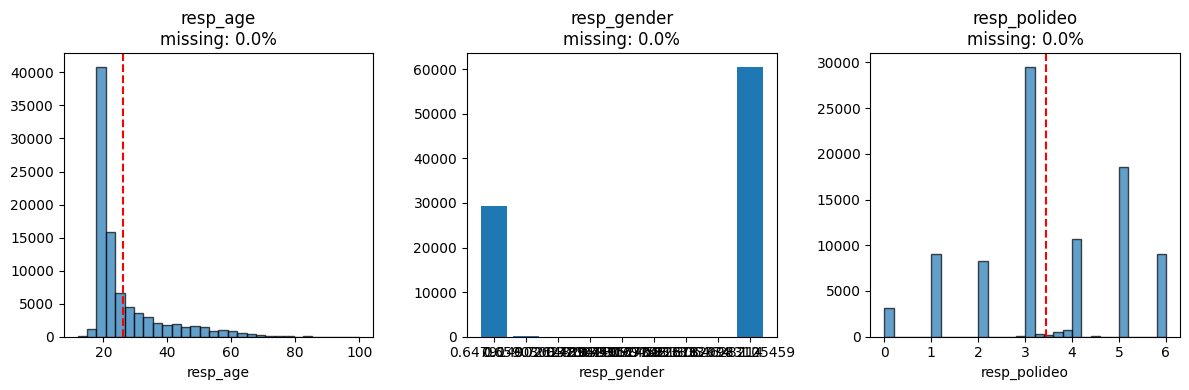

In [68]:
# Covariate distributions
if available_covs:
    fig, axes = plt.subplots(1, len(available_covs), figsize=(4*len(available_covs), 4))
    if len(available_covs) == 1:
        axes = [axes]
    
    for ax, cov in zip(axes, available_covs):
        data = df[cov].dropna()
        
        if data.nunique() > 10:
            ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
            ax.axvline(data.mean(), color='red', linestyle='--')
        else:
            counts = data.value_counts().sort_index()
            ax.bar(range(len(counts)), counts.values)
            ax.set_xticks(range(len(counts)))
            ax.set_xticklabels(counts.index)
        
        ax.set_title(f'{cov}\nmissing: {df[cov].isnull().mean()*100:.1f}%')
        ax.set_xlabel(cov)
    
    plt.tight_layout()
    plt.show()

---
## 6. Ground Truth ATE Estimation

In [69]:
# Compute ATEs from RCT (ground truth)
print("GROUND TRUTH ATES (from RCT)")
print("=" * 60)

ate_results = []
for study in df[study_col].unique():
    study_data = df[df[study_col] == study]
    
    treated = study_data[study_data['iv'] == 1]['dv'].dropna()
    control = study_data[study_data['iv'] == 0]['dv'].dropna()
    
    ate = treated.mean() - control.mean()
    se = np.sqrt(treated.var()/len(treated) + control.var()/len(control))
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(treated)-1)*treated.var() + (len(control)-1)*control.var()) / 
                         (len(treated) + len(control) - 2))
    cohens_d = ate / pooled_std if pooled_std > 0 else 0
    
    ate_results.append({
        'study': study,
        'n': len(study_data),
        'n_treated': len(treated),
        'n_control': len(control),
        'ate': ate,
        'se': se,
        'ci_lower': ate - 1.96*se,
        'ci_upper': ate + 1.96*se,
        'cohens_d': cohens_d,
        'p_value': 2 * (1 - stats.norm.cdf(abs(ate/se))) if se > 0 else 1
    })

ate_df = pd.DataFrame(ate_results).round(4)
ate_df = ate_df.sort_values('cohens_d', ascending=False)
print(ate_df.to_string(index=False))

GROUND TRUTH ATES (from RCT)
           study    n  n_treated  n_control      ate     se  ci_lower  ci_upper  cohens_d  p_value
      anchoring4 5609       2933       2676 2494.929 27.511  2441.008  2548.850     2.419    0.000
      anchoring3 5627       2764       2863 2418.373 28.898  2361.733  2475.013     2.231    0.000
      anchoring2 5284       2698       2586 2028.948 31.216  1967.764  2090.132     1.789    0.000
      anchoring1 5362       2762       2600 1555.666 36.244  1484.627  1626.704     1.171    0.000
         gambfal 5942       2680       3262    1.696  0.074     1.551     1.840     0.626    0.000
        gainloss 6271       3097       3174    0.287  0.012     0.263     0.310     0.599    0.000
             iat 5842       3982       1860    0.260  0.014     0.233     0.287     0.541    0.000
          scales 5899       2820       3079    0.175  0.009     0.156     0.193     0.497    0.000
           quote 6325       3242       3083    0.695  0.054     0.589     0.802 

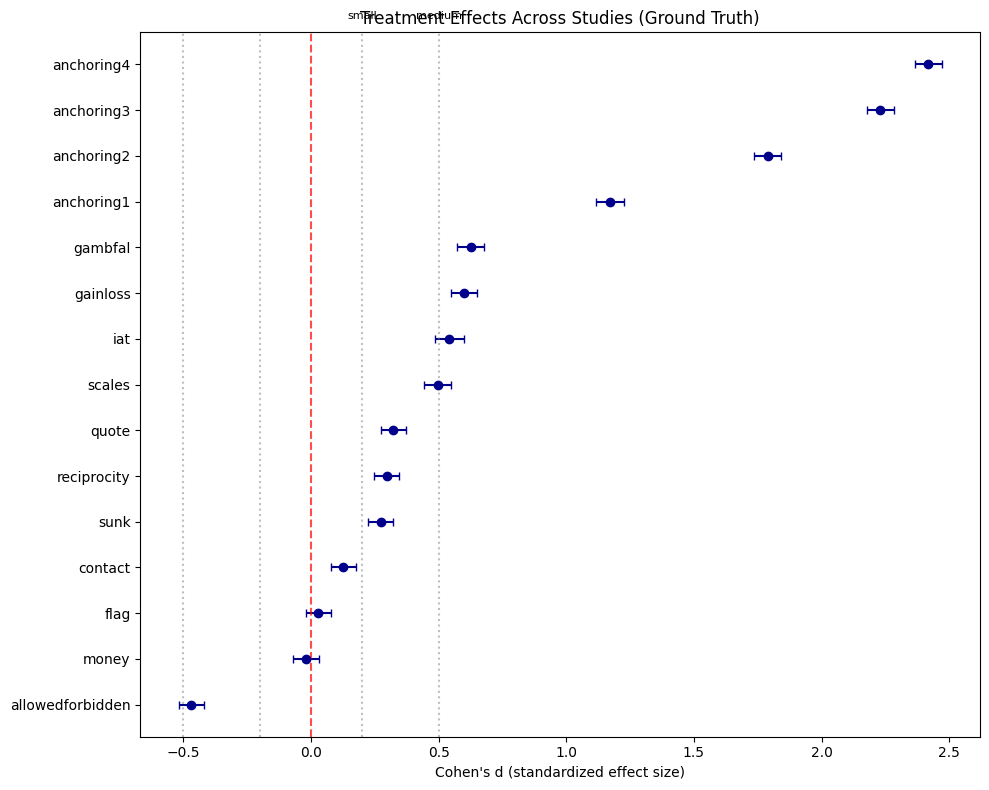

In [70]:
# Forest plot of ATEs
fig, ax = plt.subplots(figsize=(10, 8))

ate_sorted = ate_df.sort_values('cohens_d')
y_pos = range(len(ate_sorted))

# Plot effect sizes with CIs
ax.errorbar(ate_sorted['cohens_d'], y_pos, 
            xerr=1.96*ate_sorted['se']/ate_sorted['ate'].abs() * ate_sorted['cohens_d'].abs(),
            fmt='o', capsize=3, color='darkblue', markersize=6)

ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax.axvline(x=0.2, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=-0.2, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=-0.5, color='gray', linestyle=':', alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(ate_sorted['study'])
ax.set_xlabel("Cohen's d (standardized effect size)")
ax.set_title('Treatment Effects Across Studies (Ground Truth)')

# Effect size guidelines
ax.text(0.2, len(ate_sorted), 'small', fontsize=8, ha='center')
ax.text(0.5, len(ate_sorted), 'medium', fontsize=8, ha='center')

plt.tight_layout()
plt.show()

---
## 7. Readiness Assessment for OSRCT

In [71]:
# OSRCT readiness checklist
print("OSRCT READINESS ASSESSMENT")
print("=" * 60)

checks = []

# Check 1: Long format with required columns
required_cols = ['iv', 'dv', 'original_study', 'site']
missing_cols = [c for c in required_cols if c not in df.columns]
check1 = len(missing_cols) == 0
checks.append(('Required columns present', check1, f'Missing: {missing_cols}' if missing_cols else 'All present'))

# Check 2: Binary treatment
check2 = set(df['iv'].dropna().unique()) == {0, 1} or set(df['iv'].dropna().unique()) == {0.0, 1.0}
checks.append(('Binary treatment (iv)', check2, f'Values: {df["iv"].unique()}'))

# Check 3: Covariate availability
n_covs = len(available_covs)
check3 = n_covs >= 2
checks.append(('At least 2 covariates', check3, f'{n_covs} covariates available'))

# Check 4: Covariate completeness
min_cov_pct = min([df[c].notna().mean()*100 for c in available_covs]) if available_covs else 0
check4 = min_cov_pct > 50
checks.append(('Covariate completeness >50%', check4, f'Min: {min_cov_pct:.1f}%'))

# Check 5: Multiple studies
n_studies = df[study_col].nunique() if study_col in df.columns else 0
check5 = n_studies >= 5
checks.append(('At least 5 studies', check5, f'{n_studies} studies'))

# Check 6: Multiple sites
n_sites = df['site'].nunique() if 'site' in df.columns else 0
check6 = n_sites >= 10
checks.append(('At least 10 sites', check6, f'{n_sites} sites'))

# Check 7: Adequate sample size per study
min_study_n = df.groupby(study_col).size().min() if study_col in df.columns else 0
check7 = min_study_n >= 500
checks.append(('Min 500 obs per study', check7, f'Min: {min_study_n}'))

# Check 8: Treatment balance
overall_treatment_rate = df['iv'].mean()
check8 = 0.3 < overall_treatment_rate < 0.7
checks.append(('Treatment rate 30-70%', check8, f'{overall_treatment_rate:.1%}'))

# Print results
all_passed = True
for check_name, passed, detail in checks:
    status = '✓' if passed else '✗'
    print(f"{status} {check_name}: {detail}")
    if not passed:
        all_passed = False

print("\n" + "=" * 60)
if all_passed:
    print("READY FOR OSRCT GENERATION")
else:
    print("SOME ISSUES NEED ATTENTION")

OSRCT READINESS ASSESSMENT
✓ Required columns present: All present
✓ Binary treatment (iv): Values: [1. 0.]
✓ At least 2 covariates: 3 covariates available
✓ Covariate completeness >50%: Min: 100.0%
✓ At least 5 studies: 15 studies
✓ At least 10 sites: 36 sites
✓ Min 500 obs per study: Min: 5284
✓ Treatment rate 30-70%: 50.9%

READY FOR OSRCT GENERATION


In [72]:
# Export summary for pipeline
summary = {
    'n_observations': len(df),
    'n_studies': n_studies,
    'n_sites': n_sites,
    'n_covariates': n_covs,
    'covariate_completeness_min': min_cov_pct,
    'treatment_rate': overall_treatment_rate,
    'min_study_size': min_study_n,
    'ready_for_osrct': all_passed,
    'issues': [name for name, passed, _ in checks if not passed]
}

print("\nPIPELINE SUMMARY")
print("=" * 60)
for k, v in summary.items():
    print(f"{k}: {v}")


PIPELINE SUMMARY
n_observations: 89979
n_studies: 15
n_sites: 36
n_covariates: 3
covariate_completeness_min: 100.0
treatment_rate: 0.5093744095844586
min_study_size: 5284
ready_for_osrct: True
issues: []


---
## Follow Ups
 

1. **OSRCT Generation**: Use `osrct.py` to create confounded datasets
2. **Parameter Selection**: Choose beta values based on desired confounding strength
3. **Covariate Selection**: Select covariates for confounding pattern